Step 1: Install Necessary Libraries

In [1]:
!pip install yfinance numpy pandas matplotlib scikit-learn tensorflow


Step 2: Download Forex Data

In [2]:
import yfinance as yf
import pandas as pd

# List of currency pairs (symbols)
symbols = [
    'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'AUDUSD=X',
    'USDCAD=X', 'USDCHF=X', 'NZDUSD=X', 'EURGBP=X',
    'EURJPY=X', 'GBPJPY=X'
]

# Fetch historical data for the symbols (you can specify your start and end dates)
start_date = '2022-01-01'
end_date = '2023-01-01'

def fetch_data(symbols, start_date, end_date):
    data = {}
    for symbol in symbols:
        data[symbol] = yf.download(symbol, start=start_date, end=end_date, interval="1d")
    return data

# Fetch data for all symbols
data = fetch_data(symbols, start_date, end_date)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Step 3: Data Preprocessing

In [4]:
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# Add technical indicators to the data
def add_technical_indicators(df):
    # Simple Moving Average (SMA)
    df['SMA'] = df['Close'].rolling(window=14).mean()

    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()

    return df

# Preprocess the data for each symbol
def preprocess_data(data):
    processed_data = {}  # Create a dictionary to store processed data for each symbol
    for symbol, df in data.items():
        # Add technical indicators
        df = add_technical_indicators(df)

        # Handle missing values
        df.ffill(inplace=True)  # Use forward fill to handle missing values (the warning was removed)

        # Normalize data using MinMaxScaler (scale to 0-1 range)
        scaler = MinMaxScaler(feature_range=(0, 1))
        df[['Close', 'SMA', 'RSI', 'MACD']] = scaler.fit_transform(df[['Close', 'SMA', 'RSI', 'MACD']])

        # Save the scaler for inverse transformation (later usage)
        processed_data[symbol] = {
            'data': df,  # Store the processed DataFrame
            'scaler': scaler  # Store the scaler for later inverse transformation
        }
    return processed_data

# Fetch historical data for symbols
symbols = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'AUDUSD=X', 'USDCAD=X', 'USDCHF=X', 'NZDUSD=X', 'EURGBP=X', 'EURJPY=X', 'GBPJPY=X']
start_date = '2022-01-01'
end_date = '2023-01-01'

def fetch_data(symbols, start_date, end_date):
    data = {}
    for symbol in symbols:
        data[symbol] = yf.download(symbol, start=start_date, end=end_date, interval="1d")
    return data

# Fetch and preprocess data for all symbols
data = fetch_data(symbols, start_date, end_date)
processed_data = preprocess_data(data)

# Check the processed data for one symbol
print(processed_data['EURUSD=X']['data'].head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open   Volume SMA RSI      MACD
Ticker      EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X                  
Date                                                                         
2022-01-03  0.955046  1.137592  1.128541  1.137385        0 NaN NaN  0.523620
2022-01-04  0.916777  1.132300  1.127345  1.130199        0 NaN NaN  0.503099
2022-01-05  0.906772  1.134559  1.127764  1.128541        0 NaN NaN  0.481890
2022-01-06  0.922824  1.133067  1.128554  1.131222        0 NaN NaN  0.474357
2022-01-07  0.913895  1.135976  1.129050  1.129586        0 NaN NaN  0.464228


In [5]:
# Fill NaN values using forward fill method (you can also use bfill or fillna with a constant)
def handle_nan_values(df):
    df.ffill(inplace=True)  # Forward fill
    return df

# Apply the function to handle NaN values for all symbols
for symbol, df_data in processed_data.items():
    df_data['data'] = handle_nan_values(df_data['data'])

# Check the data after handling NaN values
print(processed_data['EURUSD=X']['data'].head())


Price          Close      High       Low      Open   Volume SMA RSI      MACD
Ticker      EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X                  
Date                                                                         
2022-01-03  0.955046  1.137592  1.128541  1.137385        0 NaN NaN  0.523620
2022-01-04  0.916777  1.132300  1.127345  1.130199        0 NaN NaN  0.503099
2022-01-05  0.906772  1.134559  1.127764  1.128541        0 NaN NaN  0.481890
2022-01-06  0.922824  1.133067  1.128554  1.131222        0 NaN NaN  0.474357
2022-01-07  0.913895  1.135976  1.129050  1.129586        0 NaN NaN  0.464228


In [6]:
# Drop rows with NaN values
def drop_nan_rows(df):
    df.dropna(inplace=True)  # Remove rows with NaN values
    return df

# Apply to all symbols
for symbol, df_data in processed_data.items():
    df_data['data'] = drop_nan_rows(df_data['data'])

# Check the data after dropping NaNs
print(processed_data['EURUSD=X']['data'].head())


Price          Close      High       Low      Open   Volume       SMA  \
Ticker      EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X             
Date                                                                    
2022-01-20  0.938893  1.136893  1.133016  1.134353        0  0.986593   
2022-01-21  0.922962  1.136105  1.130224  1.131542        0  0.983963   
2022-01-24  0.937856  1.134095  1.129140  1.134095        0  0.985691   
2022-01-25  0.928538  1.132503  1.126684  1.132387        0  0.987474   
2022-01-26  0.918013  1.131350  1.127205  1.130352        0  0.987080   

Price            RSI      MACD  
Ticker                          
Date                            
2022-01-20  0.544074  0.533053  
2022-01-21  0.506990  0.515983  
2022-01-24  0.643751  0.510682  
2022-01-25  0.645777  0.501681  
2022-01-26  0.573242  0.489234  


Step 4: Feature Scaling

In [7]:
def prepare_features(df, window=60):
    features = []
    labels = []

    # Create sequences for input and output
    for i in range(window, len(df)):
        features.append(df.iloc[i-window:i][['Close', 'SMA', 'RSI', 'MACD']].values)  # Last 60 days
        labels.append(df.iloc[i]['Close'])  # Next day's close price as label

    return np.array(features), np.array(labels)

# Prepare features for all symbols
def prepare_all_data(processed_data, window=60):
    all_features = {}
    all_labels = {}

    for symbol, df_data in processed_data.items():
        df = df_data['data']
        features, labels = prepare_features(df, window)
        all_features[symbol] = features
        all_labels[symbol] = labels

    return all_features, all_labels

# Prepare features and labels
all_features, all_labels = prepare_all_data(processed_data)


Step 5: Build the LSTM Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for predicting the next day's closing price

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model for a specific symbol (e.g., EURUSD=X)
input_shape = (all_features['EURUSD=X'].shape[1], all_features['EURUSD=X'].shape[2])  # (60, 4)
model = build_model(input_shape)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Step 6: Evaluate the Model

In [9]:
# Training the model for a specific symbol (e.g., EURUSD=X)
features = all_features['EURUSD=X']
labels = all_labels['EURUSD=X']

# Train the model
model.fit(features, labels, epochs=10, batch_size=32)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0907
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0263
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0146
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0074
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0085
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0081
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0079
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0072
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0072
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0061


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
RMSE: 0.06806430014884877


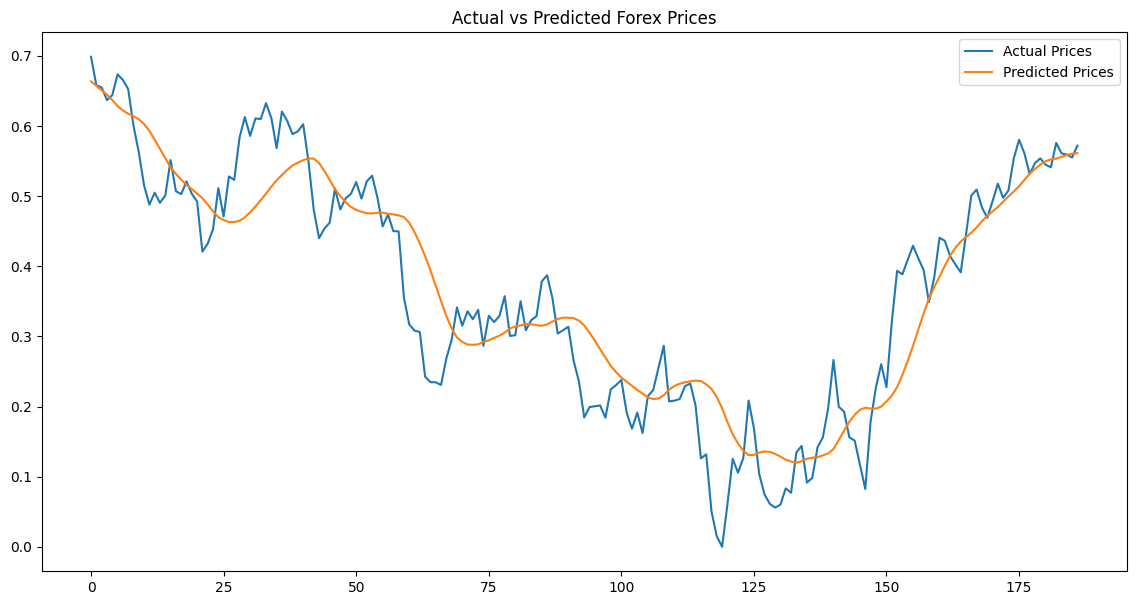

In [10]:
from sklearn.metrics import mean_squared_error

# Predict on the same features (just for testing)
predicted_prices = model.predict(features)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(labels, predicted_prices))
print(f"RMSE: {rmse}")

# Plotting the predicted vs actual prices
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(labels, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.legend()
plt.title('Actual vs Predicted Forex Prices')
plt.show()


Process for Saving the Model

Step 1: Train and Save the Model for Each Forex Symbol

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - loss: 0.1974 - val_loss: 0.0860
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - loss: 0.1037 - val_loss: 0.1595
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0841 - val_loss: 0.1261
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 0.0657 - val_loss: 0.1700
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.0611 - val_loss: 0.1074
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.0502 - val_loss: 0.1249
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0477 - val_loss: 0.1194
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0411 - val_loss: 0.1304
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.0371 - val_loss: 0.1316
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.0328 - val_loss: 0.1159
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - loss: 0.0294 - val_loss: 0.1225
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - loss: 0.0272 - val_loss: 0.1224


Model for EURUSD=X saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step
RMSE for EURUSD=X: 0.15467506961567576


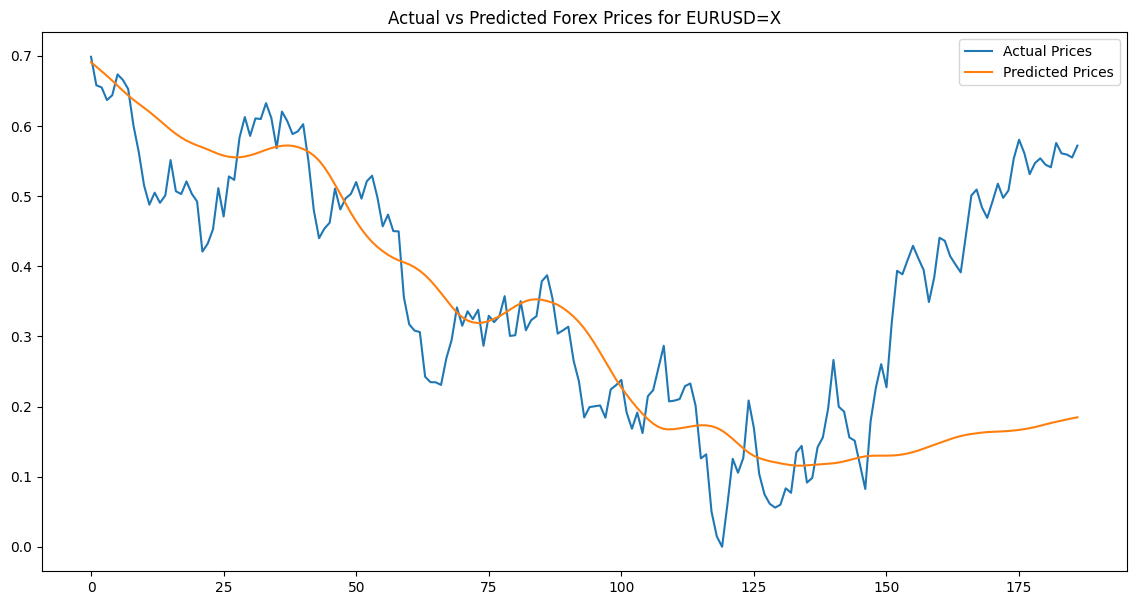

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 393ms/step - loss: 0.1685 - val_loss: 0.0745
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.0994 - val_loss: 0.0790
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - loss: 0.0791 - val_loss: 0.0617
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0726 - val_loss: 0.0717
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - loss: 0.0626 - val_loss: 0.0567
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.0556 - val_loss: 0.0888
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0519 - val_loss: 0.0826
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.0428 - val_loss: 0.0730
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.0388 - val_loss: 0.0551
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0356 - val_loss: 0.0599
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - loss: 0.0334 - val_loss: 0.0517
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0319 - val_loss: 0.0551


Model for GBPUSD=X saved successfully!


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step
RMSE for GBPUSD=X: 0.10862305646045882


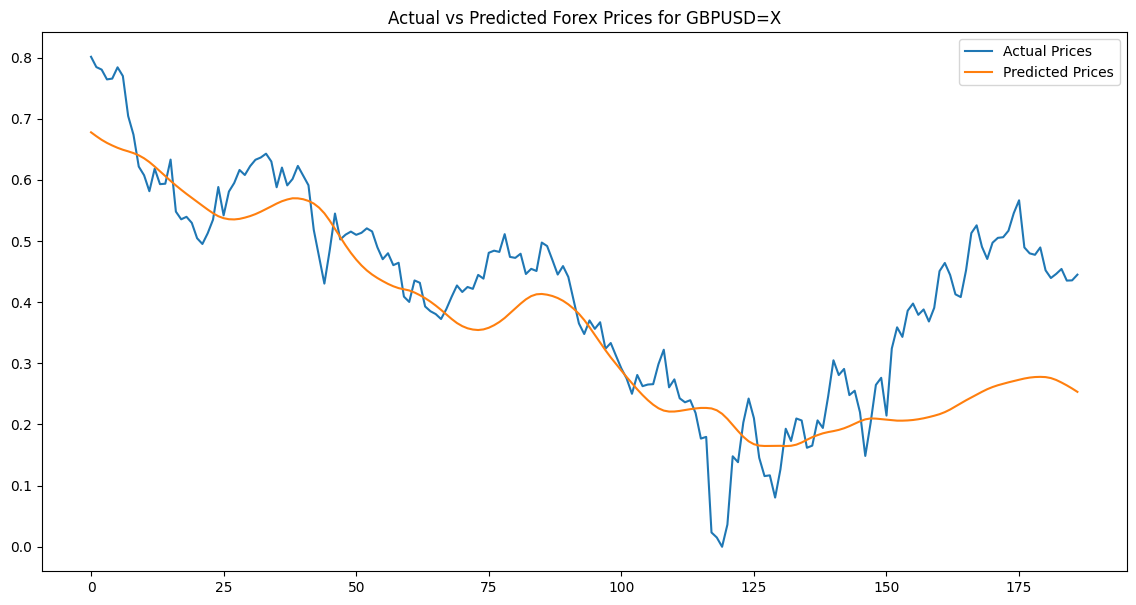

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - loss: 0.3181 - val_loss: 0.0778
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.1110 - val_loss: 0.0844
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - loss: 0.0962 - val_loss: 0.1024
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 0.0843 - val_loss: 0.0606
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0692 - val_loss: 0.1038
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0634 - val_loss: 0.0975
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0577 - val_loss: 0.0918
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.0517 - val_loss: 0.0694
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0476 - val_loss: 0.0568
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0414 - val_loss: 0.0735
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0385 - val_loss: 0.0791
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.0353 - val_loss: 0.0669


Model for USDJPY=X saved successfully!


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step
RMSE for USDJPY=X: 0.10688162750099255


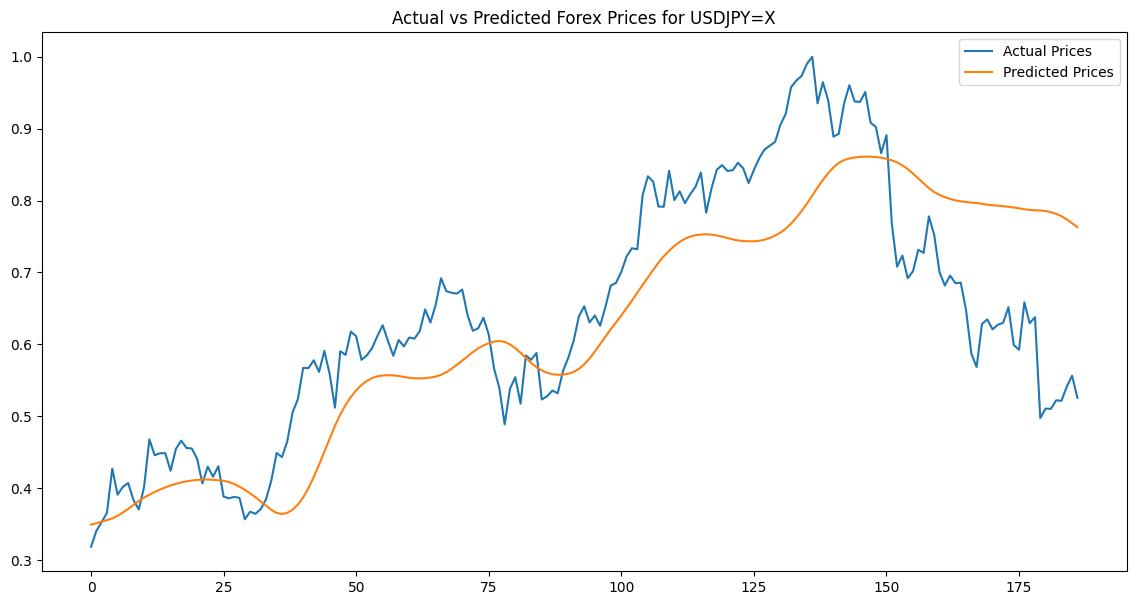

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - loss: 0.1795 - val_loss: 0.0806
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.1091 - val_loss: 0.0794
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - loss: 0.0909 - val_loss: 0.0652
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0767 - val_loss: 0.0592
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0679 - val_loss: 0.0728
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0587 - val_loss: 0.0816
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0532 - val_loss: 0.0677
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0488 - val_loss: 0.0508
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0439 - val_loss: 0.0416
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0409 - val_loss: 0.0447
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.0383 - val_loss: 0.0402
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - loss: 0.0321 - val_loss: 0.0368


Model for AUDUSD=X saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step
RMSE for AUDUSD=X: 0.08323757580156459


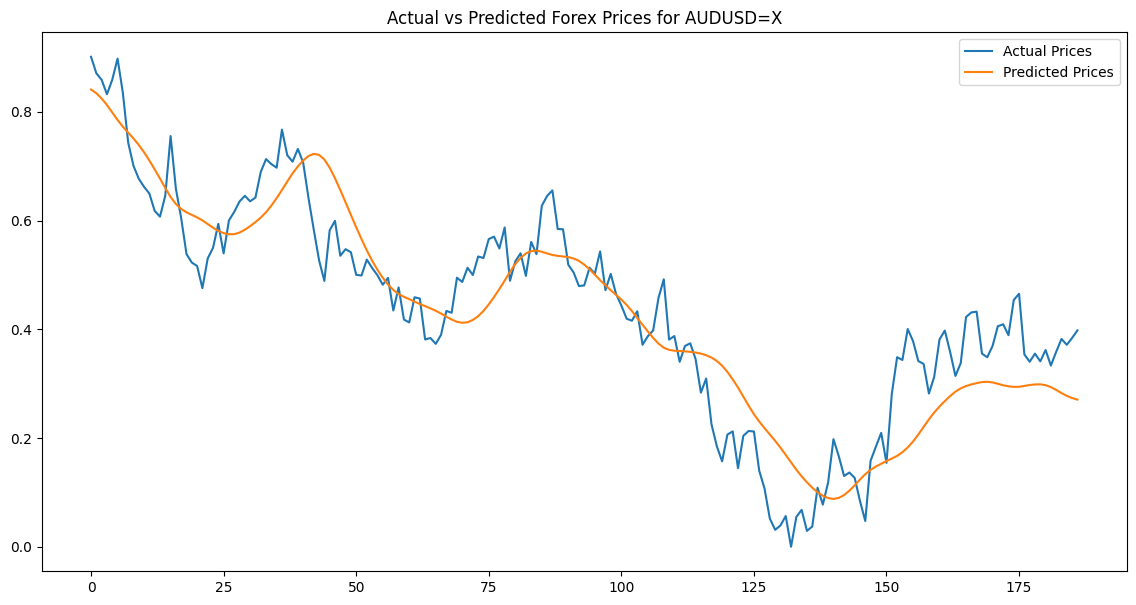

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - loss: 0.3005 - val_loss: 0.1271
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.1369 - val_loss: 0.1684
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.1130 - val_loss: 0.0862
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - loss: 0.0914 - val_loss: 0.0732
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0820 - val_loss: 0.0773
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0728 - val_loss: 0.0644
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0614 - val_loss: 0.0552
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 0.0564 - val_loss: 0.0526
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0520 - val_loss: 0.0467
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0461 - val_loss: 0.0598
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.0444 - val_loss: 0.0337
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 0.0394 - val_loss: 0.0504


Model for USDCAD=X saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
RMSE for USDCAD=X: 0.10515155917475148


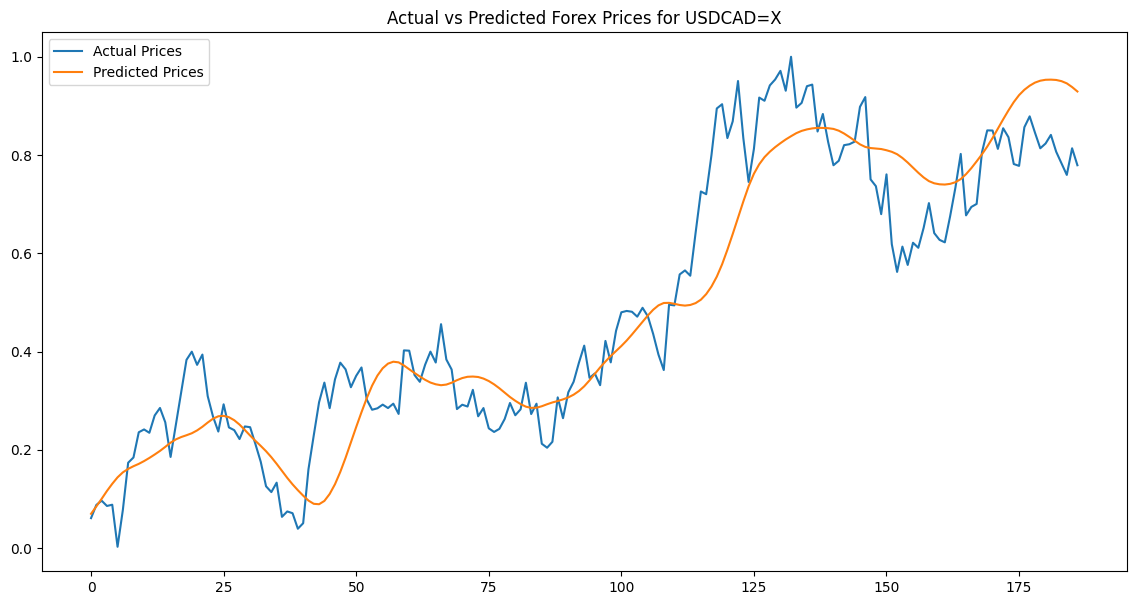

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step - loss: 0.3790 - val_loss: 0.3172
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.1215 - val_loss: 0.0786
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.1083 - val_loss: 0.1544
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0939 - val_loss: 0.1058
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0834 - val_loss: 0.0807
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0752 - val_loss: 0.1149
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step - loss: 0.0764 - val_loss: 0.0777
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0678 - val_loss: 0.0772
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0622 - val_loss: 0.0932
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0591 - val_loss: 0.0712
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0496 - val_loss: 0.0737
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0536 - val_loss: 0.0689


Model for USDCHF=X saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
RMSE for USDCHF=X: 0.15969030132466855


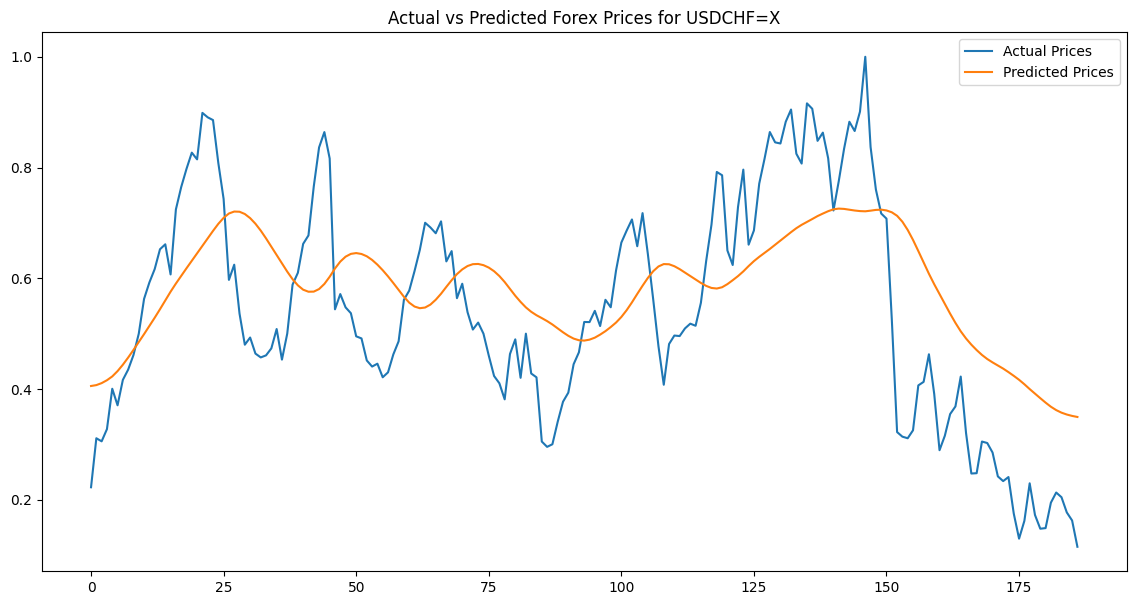

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 387ms/step - loss: 0.2224 - val_loss: 0.0749
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.0972 - val_loss: 0.0985
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 0.0810 - val_loss: 0.0697
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0726 - val_loss: 0.1058
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0652 - val_loss: 0.0845
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.0579 - val_loss: 0.0988
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - loss: 0.0499 - val_loss: 0.0797
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0469 - val_loss: 0.0668
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0405 - val_loss: 0.0722
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 0.0364 - val_loss: 0.0649
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0336 - val_loss: 0.0635
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0329 - val_loss: 0.0405


Model for NZDUSD=X saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
RMSE for NZDUSD=X: 0.09792246234672455


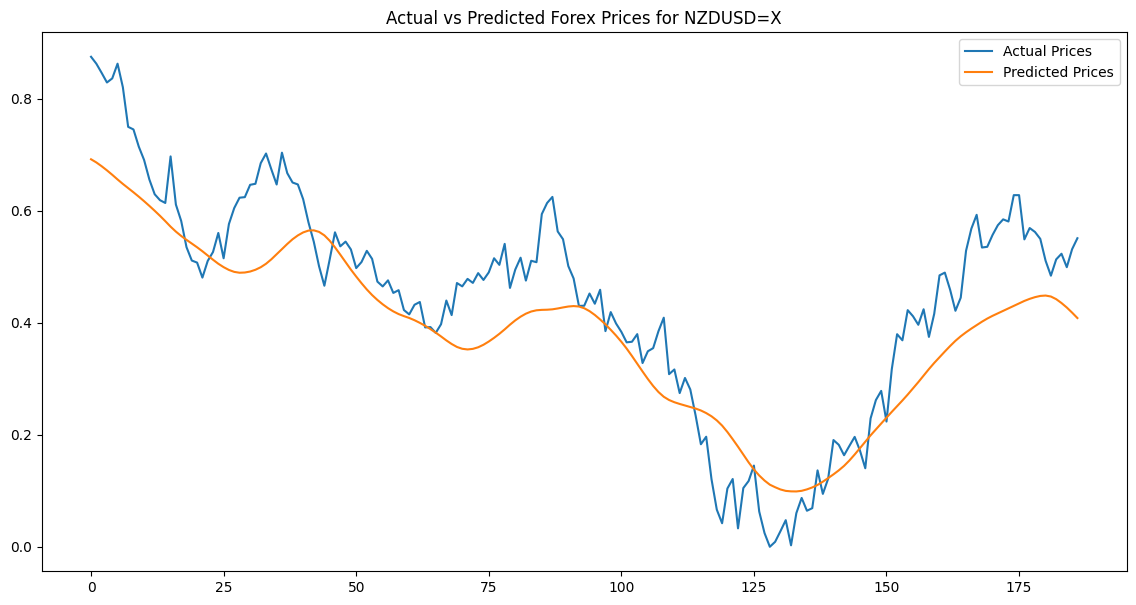

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 392ms/step - loss: 0.1173 - val_loss: 0.0768
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0826 - val_loss: 0.0745
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0698 - val_loss: 0.0607
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0642 - val_loss: 0.0597
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0604 - val_loss: 0.0481
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0493 - val_loss: 0.0460
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0429 - val_loss: 0.0379
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0384 - val_loss: 0.0344
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - loss: 0.0349 - val_loss: 0.0304
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.0344 - val_loss: 0.0261
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.0291 - val_loss: 0.0248
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0258 - val_loss: 0.0209


Model for EURGBP=X saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
RMSE for EURGBP=X: 0.07704356987761186


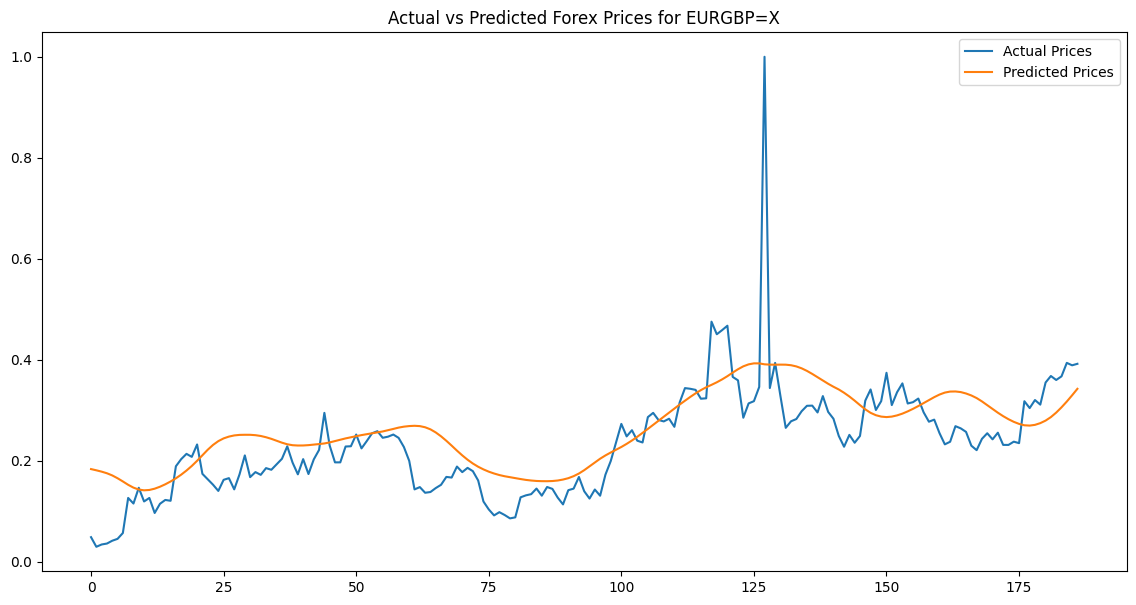

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 480ms/step - loss: 0.4120 - val_loss: 0.1410
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - loss: 0.1229 - val_loss: 0.1324
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.1072 - val_loss: 0.0731
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0940 - val_loss: 0.0869
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0864 - val_loss: 0.0626
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.0733 - val_loss: 0.0527
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0666 - val_loss: 0.0590
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0595 - val_loss: 0.0434
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0575 - val_loss: 0.0453
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - loss: 0.0560 - val_loss: 0.0381
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - loss: 0.0467 - val_loss: 0.0352
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0427 - val_loss: 0.0336


Model for EURJPY=X saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step
RMSE for EURJPY=X: 0.10419680919265725


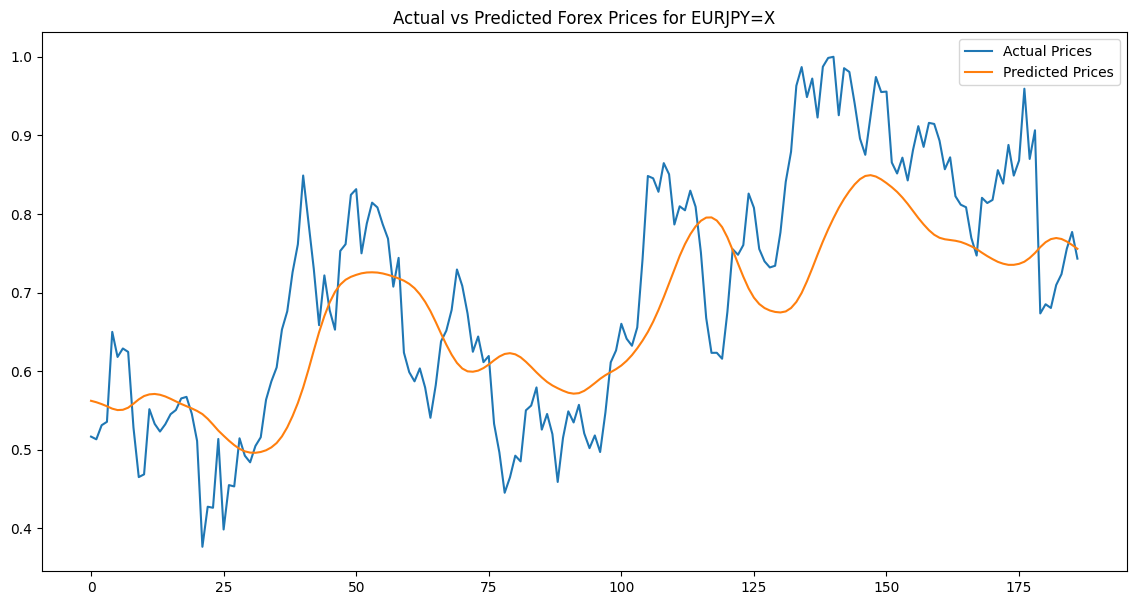

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 386ms/step - loss: 0.2784 - val_loss: 0.0948
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - loss: 0.1126 - val_loss: 0.0929
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.1037 - val_loss: 0.0766
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.0925 - val_loss: 0.0803
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0796 - val_loss: 0.0664
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0720 - val_loss: 0.0776
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0731 - val_loss: 0.0589
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0640 - val_loss: 0.0717
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0585 - val_loss: 0.0566
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0546 - val_loss: 0.0585
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - loss: 0.0493 - val_loss: 0.0682
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.0489 - val_loss: 0.0538


Model for GBPJPY=X saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
RMSE for GBPJPY=X: 0.1589226496427947


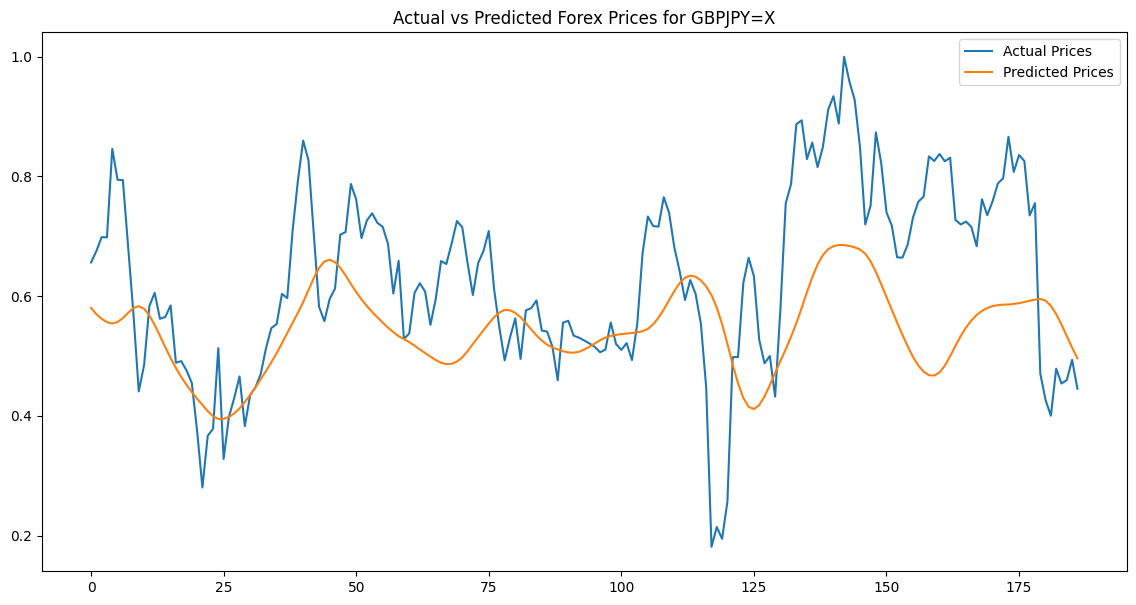

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Refined Model Architecture with LSTM + Dropout + Regularization
def build_refined_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Increased dropout to avoid overfitting
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=False))  # Adding another LSTM layer
    model.add(Dropout(0.3))
    model.add(Dense(units=64, activation='relu'))  # Adding more dense layers for deeper learning
    model.add(Dense(units=1))  # Output layer

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train and save the model for each forex symbol
def train_and_save_model(symbol, features, labels):
    input_shape = (features.shape[1], features.shape[2])  # (60, number of features)

    # Build the refined model
    model = build_refined_model(input_shape)

    # Train the model
    model.fit(features, labels, epochs=20, batch_size=32, validation_split=0.2)

    # Save the model
    model.save(f"forex_model_{symbol}.h5")
    print(f"Model for {symbol} saved successfully!")

    # Evaluate the model
    predicted_prices = model.predict(features)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(labels, predicted_prices))
    print(f"RMSE for {symbol}: {rmse}")

    # Plotting the predicted vs actual prices
    plt.figure(figsize=(14, 7))
    plt.plot(labels, label='Actual Prices')
    plt.plot(predicted_prices, label='Predicted Prices')
    plt.legend()
    plt.title(f'Actual vs Predicted Forex Prices for {symbol}')
    plt.show()

# Train and save the model for each forex symbol
for symbol in all_features.keys():
    features = all_features[symbol]
    labels = all_labels[symbol]
    train_and_save_model(symbol, features, labels)


Step 2: Model Evaluation

In [15]:
# Calculate RMSE (Root Mean Squared Error)
from sklearn.metrics import mean_squared_error

# Predict on the same features (just for testing)
predicted_prices = model.predict(features)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(labels, predicted_prices))
print(f"RMSE: {rmse}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RMSE: 0.1424765769888739


Step 3: Visualize Predicted vs Actual Prices

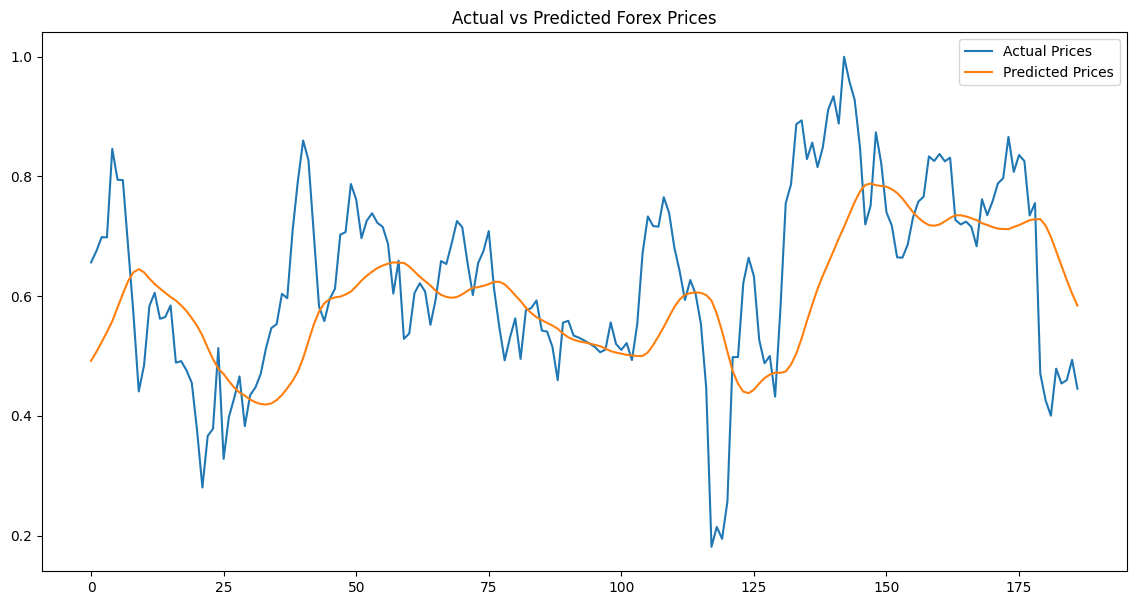

In [16]:
import matplotlib.pyplot as plt

# Plotting the predicted vs actual prices
plt.figure(figsize=(14, 7))
plt.plot(labels, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.legend()
plt.title(f'Actual vs Predicted Forex Prices')
plt.show()
